In [2]:
from PIL import Image
import os
import pandas as pd
import numpy as np
import cv2
import random

# Path to your CSV file
csv_path = '/root/ubc/train.csv'

# Load the CSV
df = pd.read_csv(csv_path)

# Filter for TMA images
tma_df = df[df['is_tma'] == True]

## TMA images are divided into tiles and labeled based on original TMAs' labels. 

#### Yes, most probably not all tiles contain cancerous tissue. But it worth a try!

In [7]:
images_path = '/root/ubc_ocean/TMA_images/train_images'
tiles_path = '/root/ubc_ocean/anar/TMA Tiles'
tile_size = 224 
tiles_data = []

# Updated function to check tissue content
def is_tissue_present(tile, area_threshold=0.55, low_saturation_threshold=20):
    # Convert PIL image to NumPy array for OpenCV processing
    tile_np = np.array(tile)
    hsv = cv2.cvtColor(tile_np, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    _, high_sat = cv2.threshold(s, low_saturation_threshold, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    tissue_mask = cv2.dilate(high_sat, kernel, iterations=2)
    tissue_mask = cv2.erode(tissue_mask, kernel, iterations=2)
    tissue_ratio = np.sum(tissue_mask > 0) / (tile_size * tile_size)
    return tissue_ratio > area_threshold

# Function to process and tile each image with tissue content check
def process_and_tile_image(image_id, label, image_path, tile_size):
    image = Image.open(os.path.join(image_path, f"{image_id}.png"))
    width, height = image.size

    for x0 in range(0, width, tile_size):
        for y0 in range(0, height, tile_size):
            x1 = x0 + tile_size
            y1 = y0 + tile_size
            if x1 <= width and y1 <= height:
                tile = image.crop((x0, y0, x1, y1))
                if is_tissue_present(tile):
                    tile_filename = f"{image_id}_{x0}_{y0}.png"
                    tile_path = os.path.join(tiles_path, tile_filename)
                    tile.save(tile_path)
                    tiles_data.append({'image_id': tile_filename, 'label': label})

for index, row in tma_df.iterrows():
    process_and_tile_image(row['image_id'], row['label'], images_path, tile_size)

tiles_df = pd.DataFrame(tiles_data)
tiles_csv_path = os.path.join(tiles_path, 'tiles.csv')
tiles_df.to_csv(tiles_csv_path, index=False)

# Visualization

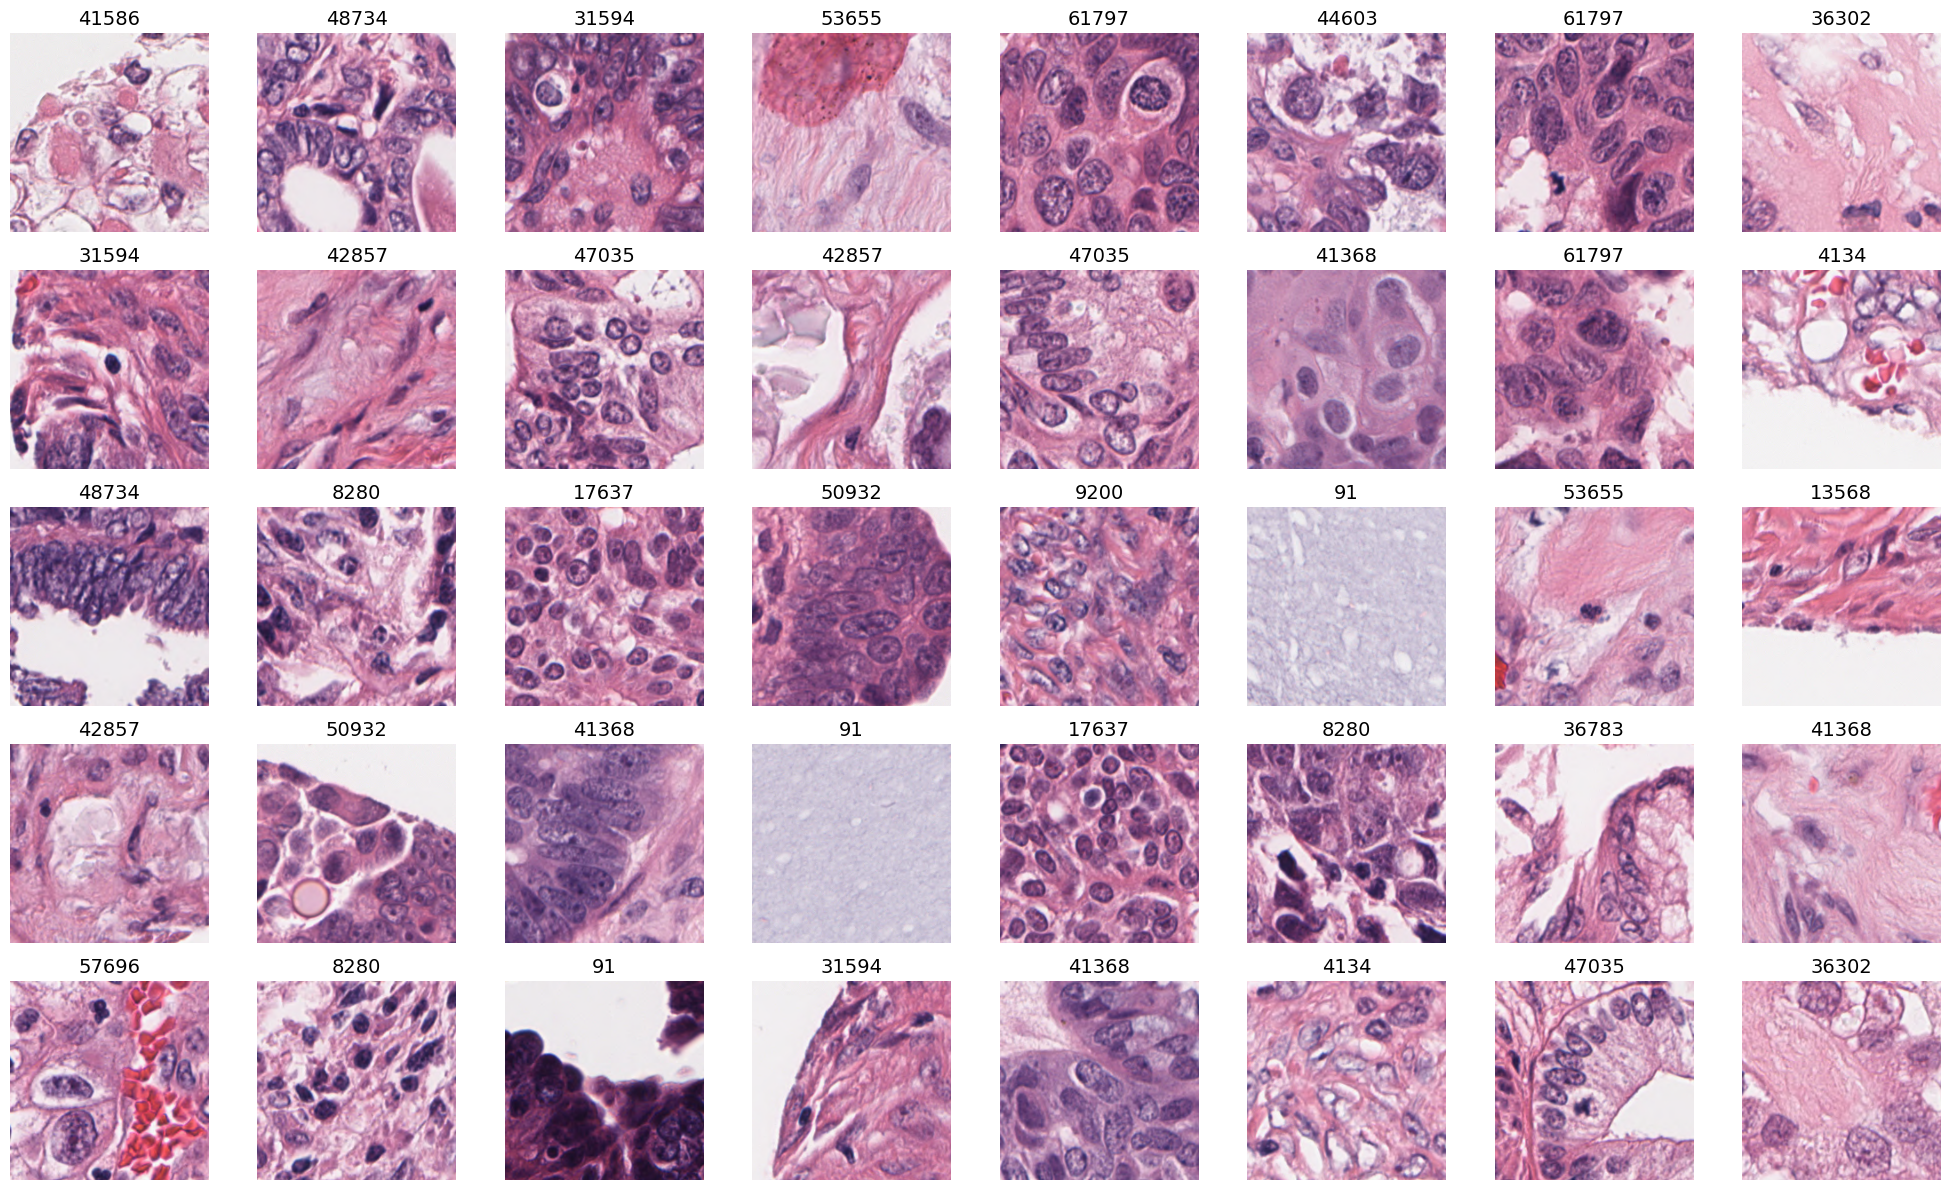

In [5]:
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

def visualize_random_tiles_from_folder(folder_path, rows=5, cols=8):
    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    
    # Randomly select a subset of images to display
    selected_files = random.sample(image_files, rows * cols)
    
    # Create the plot
    fig, axs = plt.subplots(rows, cols, figsize=(20, 12))
    for ax, img_file in zip(axs.ravel(), selected_files):
        # Load and display the image
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        ax.imshow(img)
        
        # Annotate the image with the part of its filename before the first underscore
        annotation = img_file.split('_')[0]
        ax.set_title(annotation, fontsize=14)
        
        # Hide the axes
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Path to the folder containing the tiles
tiles_folder_path = '/root/ubc_ocean/anar/TMA Tiles'
visualize_random_tiles_from_folder(tiles_folder_path)

### Training and evaluation is done in: ``TMA - training on tiles.ipynb`` notebook
#### Plese refer there for results